# Comparison of two sleep classifiers with LOOX

In this notebook, we analyze the performance of logistic regression on _Walch et al._ and a modified form we call the "hybrid motion" data set. This data set was created by taking triaxial accelerometer sampled at 50 Hz and combining with the gyroscopic measurements from a Naval platform to capture ship rotational and vibrational noise. 

We further compare logistic regression with the deep UNet model, with best performing open weights, from _Mads Olsen et al._.

Our models output, for each 30 second epoch of input recordings (accelerometer, actigraphy, and/or heart rate and other features) a probability of a particular epoch of recording corresponding to a `sleep` PSG label. When running inference to group the epochs into periods of sleep and wake (or sleep stages), we set a threshold for this probability, above which we predict an epoch sleep. For example, if a model outputs `0.71` (probability of sleep) for a given epoch, then a threshold of `0.5` will send this prediction to `sleep` since `0.71 > 0.5`, whereas a more stringent threshold of `0.76` would return a prediction of `wake` since `0.71 <= 0.76`. 

An ROC curve captures this trade-off that comes with the threshold, and also captures the fact that it's not so important that the model has probabilities spanning 0 to 1; even if the model only outputs predictions between 0.7 and 0.8, we could still pick an optimal threshold between those values as the cut-off for `sleep` or `wake` differentiation.


The metrics we will use are:
1. **AUROC**: area under ROC. 

    This is a useful way to evaluate prediction power of a trained model in highly class-imbalanced data, such as our recordings which are mostly people asleep with brief awakenings at the beginning and end, and a few places in the middle, of the recording.
2. **WASA93**: Wake accuracy when sleep accuracy is at least 93%. 

    Recalling the trade-off between scoring each class accurately and not missing epochs, for WASA93 we choose a threshold makign sleep accuracy (total fraction scored correct) at least 0.93% and then evalute the wake epochs with that threshold. This score is one way of quantifying the reliability of the prediction, especially in high-risk scenarios where monitoring awakenings during schedule sleep hours is important.

3. **Cohen's kappa**: A classical statistic that quantifies the amount to which the labels predicted (at various thresholds) have "random" agreement with the true labels. For example, when a model simply outputs the same class (ie everything is reported as `sleep`, independent of input) the kappa returns the fraction of true labels that take on that class.

# Setup & Preprocessing

We will set up some variables we'll re-use a lot, as well as preprocess the acelerometer data into spectrograms and save that data, along with its labels, in a pickled iterator.

In [2]:
!pisces_setup

2024-10-04 16:06:29.075260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 16:06:29.102086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 16:06:29.619762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Converting Mads Olsen model to Keras...
2024-10-04 16:06:30.514671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returni

In [3]:
import numpy as np
import tensorflow as tf
import pisces.models as pm
from matplotlib import pyplot as plt
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType

2024-10-04 16:06:31.885508: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 16:06:31.912287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 16:06:32.410537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set up paths for caching
Set up all the paths here, ensure the (sub)folders all exist so later when we try to save to these there are no errors.

In [4]:

import os
from pathlib import Path

CWD = Path(os.getcwd())
save_path = CWD.joinpath("pre_processed_data")
hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)
data_location = CWD.parent.joinpath('data_sets')#CWD.parent.joinpath("data_sets")

walch_preprocessed_path = walch_path.joinpath("walch_preprocessed_data.npy")
hybrid_preprocessed_path = hybrid_path.joinpath("hybrid_preprocessed_data.npy")


In [5]:

split_maker = pm.LeaveOneOutSplitter()

In [6]:
data_location

PosixPath('/home/eric/Engineering/Work/pisces/data_sets')

In [7]:
def make_mo_model_and_processor(data_set):
    sampling_hz = 32 # Hz
    input_features = ['accelerometer']
    model_input = ModelInputSpectrogram(input_features, sampling_hz)
    output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
    data_processor = DataProcessor(data_set, 
                                    model_input, 
                                    output_type=output_type,
                                    psg_type=PSGType.HAS_N4)
    mo = pm.MOResUNetPretrained(data_processor=data_processor, sampling_hz=sampling_hz)

    return mo, data_processor
def preprocess_if_needed(data_set, save_preprocessing_to, subjects_to_exclude):
    if save_preprocessing_to.exists():
        print(f"Preprocessed data found at {save_preprocessing_to}.\nSkipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.")
        return
    else:
        mo, _ = make_mo_model_and_processor(data_set)
        ids_to_preprocess = [id for id in data_set.ids if id not in subjects_to_exclude]
        preprocessed_data = [mo.get_needed_X_y(id, mo.data_processor) for id in ids_to_preprocess]
        # Prepare a bundle to save
        to_save = {
            id: data
            for (data, id) in zip(preprocessed_data, ids_to_preprocess)
            if data is not None
        }
        print(f"Saving to {save_preprocessing_to}...")
        np.save(save_preprocessing_to,
                np.array(to_save, dtype=object)
                )

## Walch

In [8]:
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects. (Should be 31)")

Found 31 subjects. (Should be 31)


In [9]:
subjects_to_exclude_walch = [
    "759667", "3509524", "7749105",
    "9961348", "5132496",
]
ids_to_split = [id for id in walch.ids if id not in subjects_to_exclude_walch]

In [10]:
preprocess_if_needed(walch, walch_preprocessed_path, subjects_to_exclude_walch)

Preprocessed data found at /home/eric/Engineering/Work/pisces/analyses/pre_processed_data/walch/walch_preprocessed_data.npy.
Skipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.


## Hybrid

In [11]:
# hybrid are a manipulation of the walch data set
# hence we want to exclude the same ones, for the same reasons
subjects_to_exclude_hybrid = subjects_to_exclude_walch

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects. (Should be 31, matching walch)")
 

Found 31 subjects. (Should be 31, matching walch)


In [12]:
preprocess_if_needed(hybrid, hybrid_preprocessed_path, subjects_to_exclude_hybrid)

Preprocessed data found at /home/eric/Engineering/Work/pisces/analyses/pre_processed_data/hybrid/hybrid_preprocessed_data.npy.
Skipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.


# Hypnogram exploration

In [13]:
import numpy as np
x = np.zeros((3, 4))

In [14]:
x[..., None].shape

(3, 4, 1)

In [15]:
x[None, ...].shape

(1, 3, 4)

In [16]:
def apply_transform_to_specgram(preprocessed_data_dict):
    for id, data in preprocessed_data_dict.items():
        X, y = data
        # reshape (*shape, 1)
        X = X[..., None]
        y = y[..., None]
        preprocessed_data_dict[id] = (X, y)
    return preprocessed_data_dict
preprocessed_data_unet = {
    walch.name: np.load(walch_preprocessed_path, allow_pickle=True).item(),
    hybrid.name: np.load(hybrid_preprocessed_path, allow_pickle=True).item(),
}

In [17]:
mo, proc = make_mo_model_and_processor(walch)
mo.load_model()

2024-10-04 16:06:33.768236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:06:33.787681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:06:33.787805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
walch_data = preprocessed_data_unet[walch.name]

In [19]:
w0_X, w0_y = walch_data[walch.ids[0]]

In [20]:
prediction = mo.predict_probabilities(w0_X)

I0000 00:00:1728075995.322296  111975 service.cc:145] XLA service 0x7299bc00ac50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728075995.322319  111975 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-04 16:06:35.347920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 16:06:35.468423: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1728075997.355968  111975 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
prediction.shape

(1024, 4)

In [22]:
w0_y.shape

(1024,)

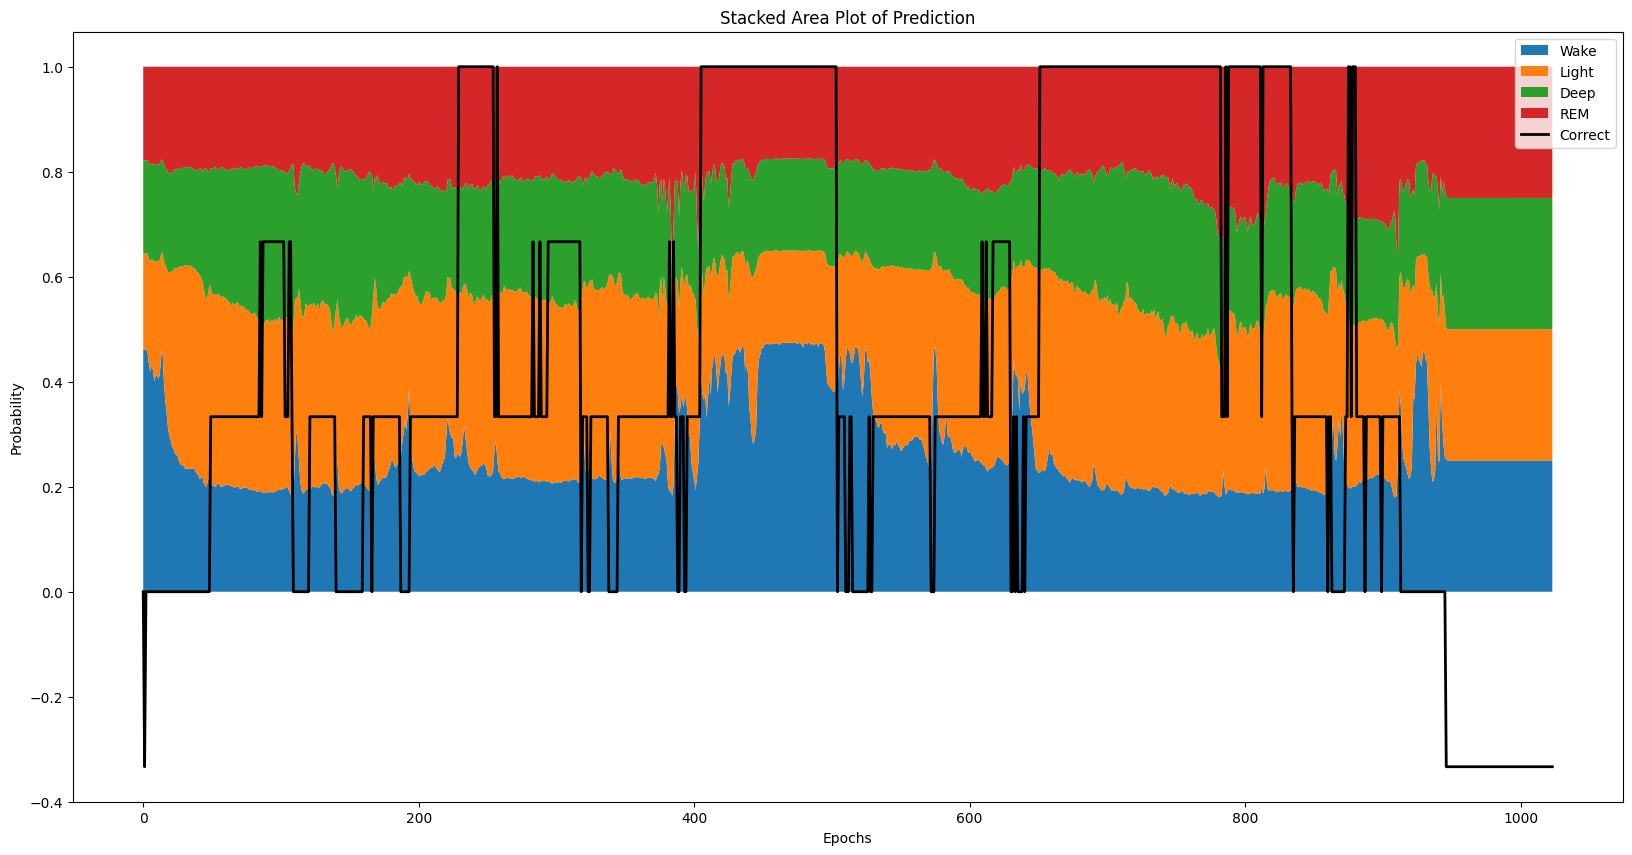

In [23]:
plt.figure(figsize=(20, 10))
plt.stackplot(range(prediction.shape[0]), prediction.T, labels=["Wake", "Light", "Deep", "REM"])
plt.plot(w0_y / 3, label="Correct", color='black', linewidth=2)
plt.legend(loc='upper right')
plt.title("Stacked Area Plot of Prediction")
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.show()

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# Define the model
def create_sequential_model(input_shape, layer_dims, output_dims=2):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for dim in layer_dims:
        model.add(Dense(dim, activation='linear'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    model.add(Dense(output_dims, activation='softmax'))
    return model

def create_cnn_model(input_shape, conv_layers, dense_layers, output_dims=2):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    
    for filters, kernel_size, pool_size in conv_layers:
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    
    for units in dense_layers:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(output_dims, activation='softmax'))
    return model

# Example usage
input_shape = (64, 64, 3)  # Example input shape
conv_layers = [
    (32, (3, 3), (2, 2)),
    (64, (3, 3), (2, 2)),
    (128, (3, 3), (2, 2))
]
dense_layers = [128, 64]

cnn_model = create_cnn_model(input_shape, conv_layers, dense_layers)
cnn_model.summary()

/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,586 (2.64 MB)

 Trainable params: 691,586 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
N_EPOCHS = 1024
evaluated_data = [mo.predict_probabilities(data[0]).reshape((1, N_EPOCHS, 4)) for data in walch_data.values()]

evaluated_labels = [data[1].reshape(1, N_EPOCHS) for data in walch_data.values()]
evaluated_ws_labels = [
    np.where
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
evaluated_data[0].shape

(1, 1024, 4)

In [27]:
evaluated_labels[0].shape

(1, 1024)

In [28]:
np.concatenate(evaluated_data).shape

(26, 1024, 4)

In [29]:
model = create_sequential_model(
    input_shape=(1024, 4), 
    layer_dims=[64, 64, 64],
    output_dims=2)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

splits = split_maker.split(evaluated_data)

for train, test in splits:
    train_data = [evaluated_data[i] for i in train]
    test_data = [evaluated_data[i] for i in test]

    train_labels = [evaluated_labels[i] for i in train]
    test_labels = [evaluated_labels[i] for i in test]

    X_train = np.concatenate(train_data)
    X_test = np.concatenate(test_data)

    y_train = np.concatenate(train_labels)
    y_test = np.concatenate(test_labels)

    y_train = np.where(y_train == -1, 4, y_train)
    y_test = np.where(y_test == -1, 4, y_test)

    n_train = len(y_train) * 0.25

    class_weights = {
        # -1: 0.0,
        0: n_train / max(np.sum(y_train == 0), 1),
        1: n_train / max(np.sum(y_train == 1), 1),
        2: n_train / max(np.sum(y_train == 2), 1),
        3: n_train / max(np.sum(y_train == 3), 1),
        4: 0.0
    }

    model.fit(X_train, y_train, epochs=10, batch_size=1, class_weight=class_weights)
    model.evaluate(X_test, y_test)

Epoch 1/10


/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.4591 - loss: nan
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.5028 - loss: nan
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.4961 - loss: nan
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.5342 - loss: nan
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.4294 - loss: nan
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.4972 - loss: nan
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.5273 - loss: nan
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.4888 - loss: nan
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.4912 - loss: nan
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.4678 - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3867 - loss: nan
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.5362 - loss: nan
Epoch 2/10
25/25 ━━━━━━━━━━

W0000 00:00:1728076000.272528  111972 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5036 - loss: nan
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.5014 - loss: nan
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.5121 - loss: nan
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.5149 - loss: nan
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.5063 - loss: nan
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.4532 - loss: nan
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.5114 - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4492 - loss: nan
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.5310 - loss: nan
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.4959 - loss: nan
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.4871 - loss: nan
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.4952 - loss: nan
Epoch 5/10
25/25 ━━━━━━━━━━━

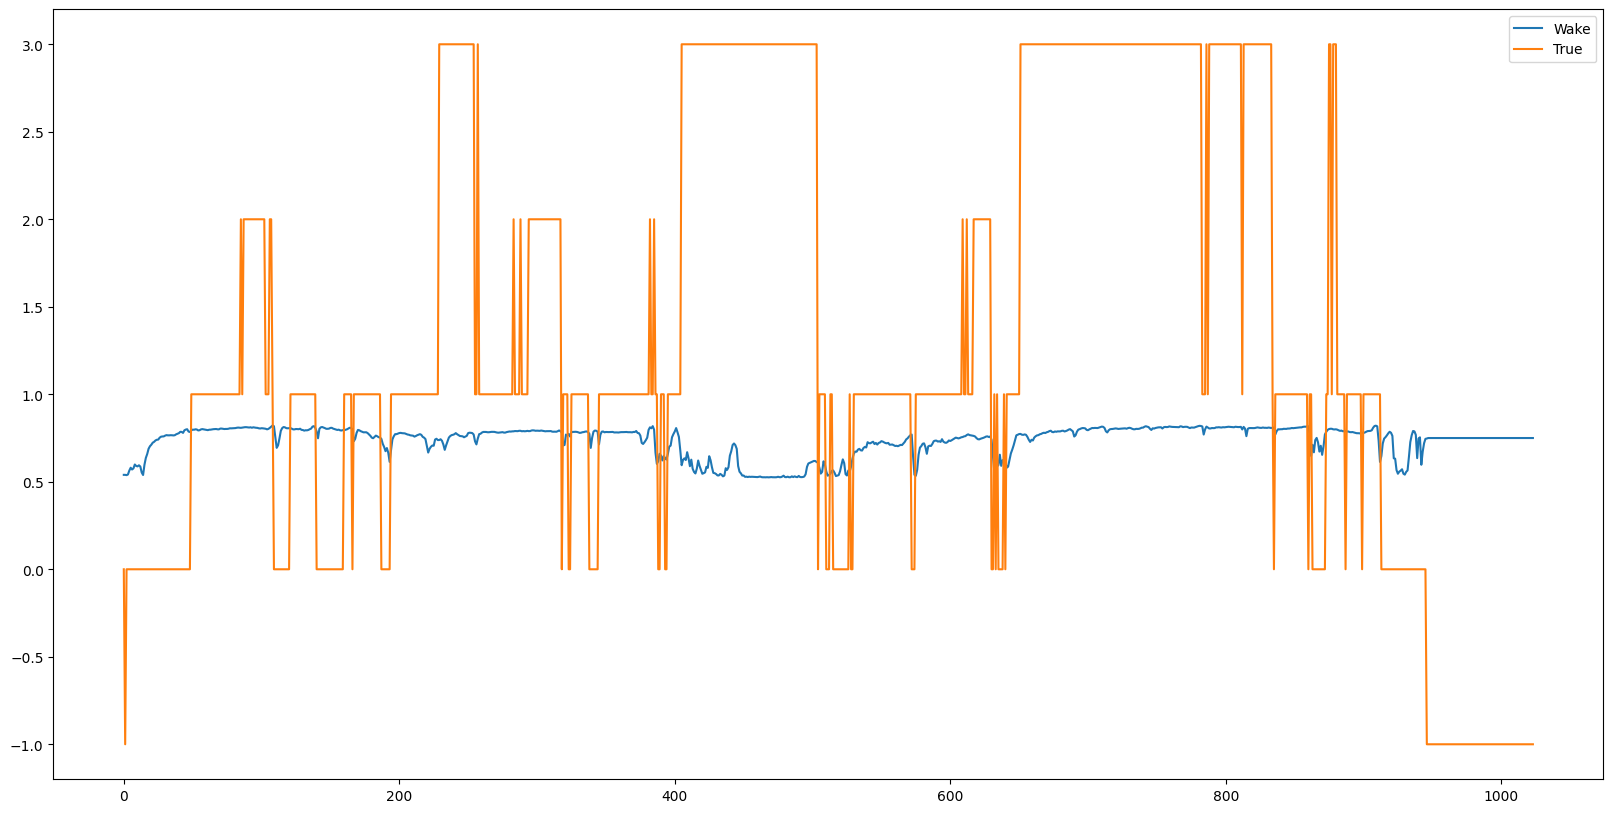

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(1 - prediction[:, 0], label="Wake")
plt.plot(w0_y, label="True")

plt.legend()


# Logistic Regression

In [31]:
# Train with top scoring hyperparameters
from typing import Callable, Tuple


log_reg_hyperparameters = {
    'penalty': None,
    'alpha': 10,
    'fit_intercept': False,
    'learning_rate': 'adaptive',
    'eta0': 0.0001,
    'random_state': 42,
}


def make_lr_model(data_set: DataSetObject, **log_reg_hyperparameters) -> Tuple[Callable, DataProcessor]:

    sampling_hz = 1.0 / 15.0
    output_type = pm.ModelOutputType.SLEEP_WAKE
    window_size_seconds = 300
    input_features = ['activity']
    max_iter = 2000
    class_weight = "balanced"
    n_iter_no_change = 15
    model_input = pm.ModelInput1D(input_features, sampling_hz, window_size_seconds)
    data_processor = DataProcessor(data_set, model_input, output_type=output_type)
    def model_fn():
        return pm.SGDLinearClassifier(data_processor, **log_reg_hyperparameters)
    return model_fn, data_processor

For the purposes of using LOO and LOOX cross-validation, we need to have both LR preprocessed data loaded, for passing into our evaluation functions.

In [32]:
from tqdm import tqdm


swc_walch_fn, walch_data_processor_1D = make_lr_model(walch, **log_reg_hyperparameters)
swc_hybrid_fn, walch_data_processor_1D = make_lr_model(hybrid, **log_reg_hyperparameters)
swc_walch = swc_walch_fn()
swc_hybrid = swc_hybrid_fn()
tqdm_message_preprocess = f"Preparing data for {len(ids_to_split)} IDs"
preprocessed_data_log_reg = {
    walch.name:  {id: swc_walch.get_needed_X_y(id) for id in tqdm(ids_to_split, desc=tqdm_message_preprocess)},
    hybrid.name:  {id: swc_hybrid.get_needed_X_y(id) for id in tqdm(ids_to_split, desc=tqdm_message_preprocess)},
}

Preparing data for 26 IDs: 100%|██████████| 26/26 [00:00<00:00, 217.15it/s]


Training 26 splits:   8%|▊         | 2/26 [00:00<00:01, 16.22it/s]

Training on labels with shape (915,)
Training on 22871 examples
Training on labels with shape (22871,)
Done fitting

Training on labels with shape (936,)
Training on 22892 examples
Training on labels with shape (22892,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)
Done fitting

Training on labels with shape (936,)
Training on 22829 examples
Training on labels with shape (22829,)


Training 26 splits:  23%|██▎       | 6/26 [00:00<00:01, 16.70it/s]

Done fitting

Training on labels with shape (936,)
Training on 22831 examples
Training on labels with shape (22831,)
Done fitting

Training on labels with shape (936,)
Training on 22836 examples
Training on labels with shape (22836,)
Done fitting

Training on labels with shape (936,)
Training on 22850 examples
Training on labels with shape (22850,)
Done fitting

Training on labels with shape (936,)
Training on 22842 examples
Training on labels with shape (22842,)


Training 26 splits:  38%|███▊      | 10/26 [00:00<00:00, 16.80it/s]

Done fitting

Training on labels with shape (936,)
Training on 23319 examples
Training on labels with shape (23319,)
Done fitting

Training on labels with shape (936,)
Training on 22849 examples
Training on labels with shape (22849,)
Done fitting

Training on labels with shape (936,)
Training on 22839 examples
Training on labels with shape (22839,)
Done fitting

Training on labels with shape (936,)
Training on 23252 examples
Training on labels with shape (23252,)


Training 26 splits:  54%|█████▍    | 14/26 [00:00<00:00, 16.78it/s]

Done fitting

Training on labels with shape (936,)
Training on 22841 examples
Training on labels with shape (22841,)
Done fitting

Training on labels with shape (936,)
Training on 23060 examples
Training on labels with shape (23060,)
Done fitting

Training on labels with shape (936,)
Training on 22857 examples
Training on labels with shape (22857,)
Done fitting

Training on labels with shape (936,)
Training on 22837 examples
Training on labels with shape (22837,)


Training 26 splits:  69%|██████▉   | 18/26 [00:01<00:00, 16.68it/s]

Done fitting

Training on labels with shape (936,)
Training on 22838 examples
Training on labels with shape (22838,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)
Done fitting

Training on labels with shape (936,)
Training on 22834 examples
Training on labels with shape (22834,)
Done fitting

Training on labels with shape (936,)
Training on 22847 examples
Training on labels with shape (22847,)


Training 26 splits:  85%|████████▍ | 22/26 [00:01<00:00, 16.80it/s]

Done fitting

Training on labels with shape (936,)
Training on 22870 examples
Training on labels with shape (22870,)
Done fitting

Training on labels with shape (936,)
Training on 22853 examples
Training on labels with shape (22853,)
Done fitting

Training on labels with shape (936,)
Training on 22848 examples
Training on labels with shape (22848,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)


Training 26 splits: 100%|██████████| 26/26 [00:01<00:00, 16.76it/s]

Done fitting

Training on labels with shape (936,)
Training on 22844 examples
Training on labels with shape (22844,)
Done fitting

Training on labels with shape (936,)
Training on 22874 examples
Training on labels with shape (22874,)
Done fitting



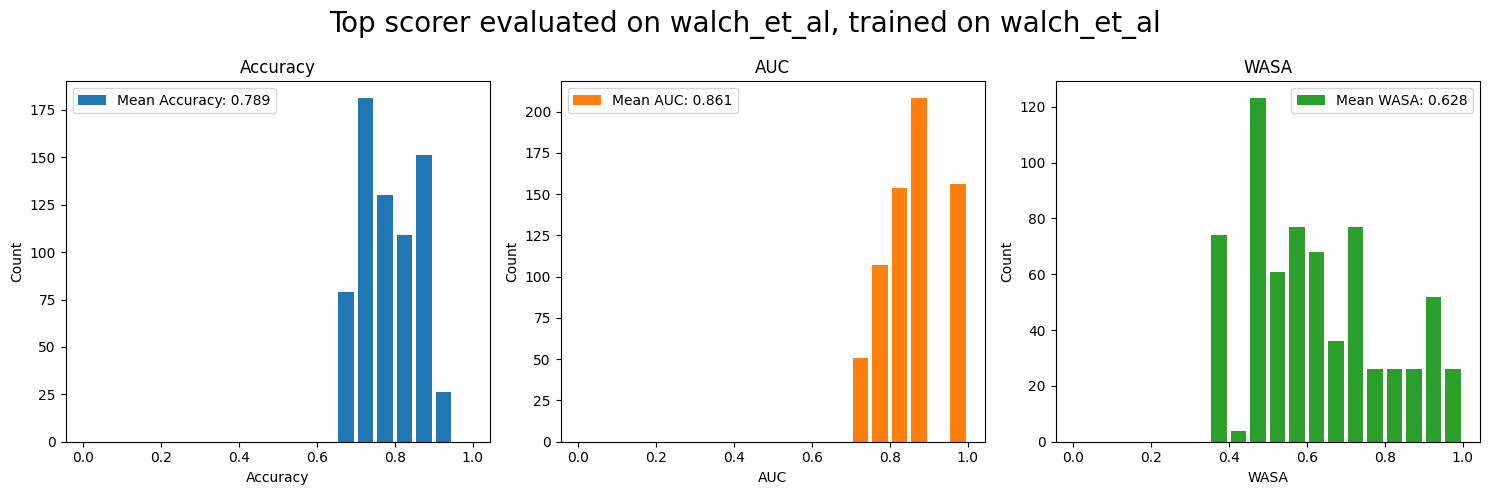

In [33]:
TRAIN_SET = walch.name
EVAL_SET = walch.name
PLOT_TITLE = f'Top scorer evaluated on {EVAL_SET}, trained on {TRAIN_SET}'

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

models = []
splits = []

model_fn, _ = make_lr_model(walch, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_log_reg[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_log_reg[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    model, _ = pm.run_split(train_indices=train_ids, 
                            preprocessed_data_set=training_preprocessed_data, 
                            swc=model_fn(), epochs=None, do_not_train=False)
    models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()

Training 26 splits:   8%|▊         | 2/26 [00:00<00:01, 16.10it/s]

Training on labels with shape (915,)
Training on 22871 examples
Training on labels with shape (22871,)
Done fitting

Training on labels with shape (936,)
Training on 22892 examples
Training on labels with shape (22892,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)
Done fitting

Training on labels with shape (936,)
Training on 22829 examples
Training on labels with shape (22829,)


Training 26 splits:  23%|██▎       | 6/26 [00:00<00:01, 16.66it/s]

Done fitting

Training on labels with shape (936,)
Training on 22831 examples
Training on labels with shape (22831,)
Done fitting

Training on labels with shape (936,)
Training on 22836 examples
Training on labels with shape (22836,)
Done fitting

Training on labels with shape (936,)
Training on 22850 examples
Training on labels with shape (22850,)
Done fitting

Training on labels with shape (936,)
Training on 22842 examples
Training on labels with shape (22842,)


Training 26 splits:  38%|███▊      | 10/26 [00:00<00:00, 16.76it/s]

Done fitting

Training on labels with shape (936,)
Training on 23319 examples
Training on labels with shape (23319,)
Done fitting

Training on labels with shape (936,)
Training on 22849 examples
Training on labels with shape (22849,)
Done fitting

Training on labels with shape (936,)
Training on 22839 examples
Training on labels with shape (22839,)
Done fitting

Training on labels with shape (936,)
Training on 23252 examples
Training on labels with shape (23252,)


Training 26 splits:  54%|█████▍    | 14/26 [00:00<00:00, 16.69it/s]

Done fitting

Training on labels with shape (936,)
Training on 22841 examples
Training on labels with shape (22841,)
Done fitting

Training on labels with shape (936,)
Training on 23060 examples
Training on labels with shape (23060,)
Done fitting

Training on labels with shape (936,)
Training on 22857 examples
Training on labels with shape (22857,)
Done fitting

Training on labels with shape (936,)
Training on 22837 examples
Training on labels with shape (22837,)


Training 26 splits:  69%|██████▉   | 18/26 [00:01<00:00, 16.54it/s]

Done fitting

Training on labels with shape (936,)
Training on 22838 examples
Training on labels with shape (22838,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)
Done fitting

Training on labels with shape (936,)
Training on 22834 examples
Training on labels with shape (22834,)
Done fitting

Training on labels with shape (936,)
Training on 22847 examples
Training on labels with shape (22847,)


Training 26 splits:  85%|████████▍ | 22/26 [00:01<00:00, 16.70it/s]

Done fitting

Training on labels with shape (936,)
Training on 22870 examples
Training on labels with shape (22870,)
Done fitting

Training on labels with shape (936,)
Training on 22853 examples
Training on labels with shape (22853,)
Done fitting

Training on labels with shape (936,)
Training on 22848 examples
Training on labels with shape (22848,)
Done fitting

Training on labels with shape (936,)
Training on 22854 examples
Training on labels with shape (22854,)


Training 26 splits: 100%|██████████| 26/26 [00:01<00:00, 16.67it/s]

Done fitting

Training on labels with shape (936,)
Training on 22844 examples
Training on labels with shape (22844,)
Done fitting

Training on labels with shape (936,)
Training on 22874 examples
Training on labels with shape (22874,)
Done fitting



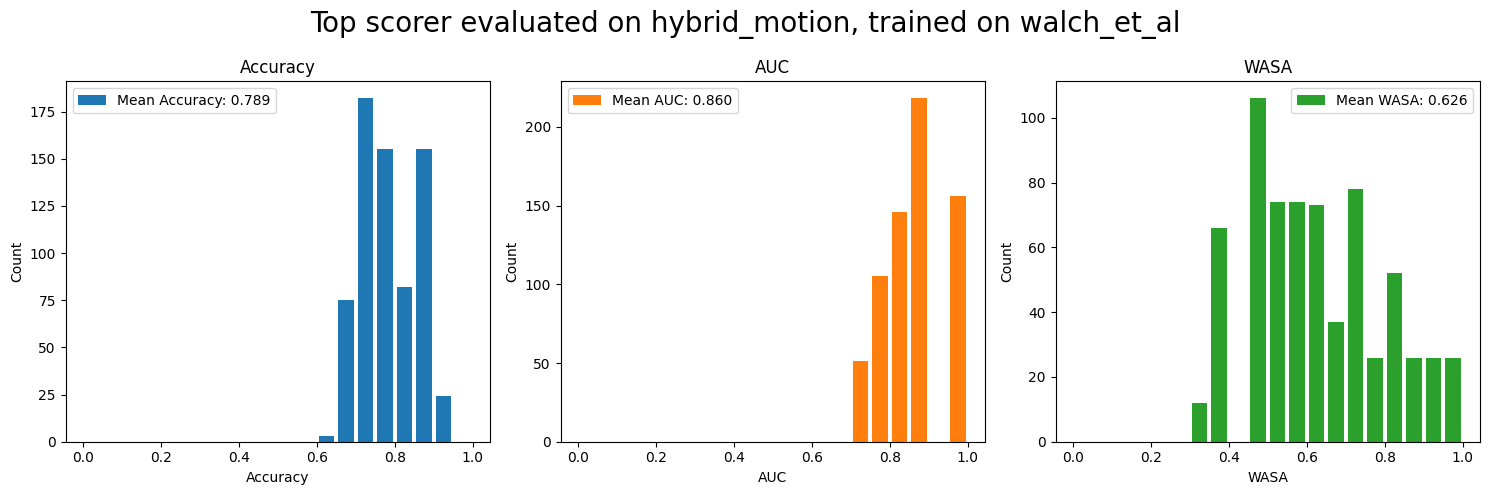

In [34]:
TRAIN_SET = walch.name
EVAL_SET = hybrid.name
PLOT_TITLE = f'Top scorer evaluated on {EVAL_SET}, trained on {TRAIN_SET}'

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

models = []
splits = []

model_fn, _ = make_lr_model(hybrid, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_log_reg[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_log_reg[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    model, _ = pm.run_split(train_indices=train_ids, 
                            preprocessed_data_set=training_preprocessed_data, 
                            swc=model_fn(), epochs=None)
    models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()

# Deep UNet from Mads Olsen's group

In [35]:
text_indices = [walch.ids[0]]
train_indices = [i for i in walch.ids[1:] if i not in subjects_to_exclude_walch]
preprocessed_data_set = preprocessed_data_unet[walch.name]
training_pairs = [
    [preprocessed_data_set[i][0], preprocessed_data_set[i][1].reshape(1, -1)]
    # [preprocessed_data_set[i][0], preprocessed_data_set[i][1]]
    for i in train_indices
    if preprocessed_data_set.get(i) is not None
]

In [36]:
mo, _ = make_mo_model_and_processor(walch)
mo.initial_lr = 0.00001
mo.load_model()
swc = mo
extra_params = {
    f'{swc.model_pipeline_name}__epochs': 100,
    f'{swc.model_pipeline_name}__batch_size': 1,
    f'{swc.model_pipeline_name}__validation_split': 0.1
}
print(swc.pipeline.named_steps)
result = swc.train(pairs_Xy=training_pairs, **extra_params)

{'model': <Functional name=functional_1, built=True>}
Training on 25 examples
Training on labels with shape (25, 1024)
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - loss: 1.8049 - sparse_categorical_accuracy: 0.5492 - val_loss: 0.8530 - val_sparse_categorical_accuracy: 0.6133
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.4827 - sparse_categorical_accuracy: 0.5602 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.5941
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.6436 - sparse_categorical_accuracy: 0.5381 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.5885
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.4787 - sparse_categorical_accuracy: 0.5483 - val_loss: 0.9441 - val_sparse_categorical_accuracy: 0.5778
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.5641 - sparse_categorical_accuracy: 0.5365 - val_loss: 0.9822 - val_sparse_categorical_accuracy: 0.5801
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/st

/home/eric/Engineering/Work/pisces/pisces/models.py:151: UserWarning: Failed to fetch loss history. Returning empty list.
  warnings.warn("Failed to fetch loss history. Returning empty list.")


In [45]:
import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt

def plot_line(y_value):
    plt.figure(figsize=(10, 5))
    plt.plot([0, 1], [y_value, y_value], label=f'y = {y_value}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Line Plot with Slider')
    plt.legend()
    plt.show()

slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Y Value:')
interact(plot_line, y_value=slider)

interactive(children=(FloatSlider(value=0.5, description='Y Value:', max=1.0, step=0.01), Output()), _dom_clas…

<function __main__.plot_line(y_value)>

In [67]:
def plot_eval_from_scalar(scalar):
    TRAIN_SET = walch.name
    EVAL_SET = walch.name
    PLOT_TITLE = f"Mads Olsen's UNet evaluated on {EVAL_SET}"

    from analyses.utils.metrics import calculate_metrics_from_splits


    tqdm_message_train = f"Training {len(ids_to_split)} splits"
    all_splits = split_maker.split(ids_to_split)

    mo, _ = make_mo_model_and_processor(walch)
    mo.load_model(force=True)
    models = [swc]
    splits = []
    # model_fn = make_model(walch_data_processor_1D, **log_reg_hyperparameters)

    training_preprocessed_data = preprocessed_data_unet[TRAIN_SET]
    evaluate_preprocessed_data = preprocessed_data_unet[EVAL_SET]
    for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
        train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
        test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
        # model, _ = pm.run_split(train_indices=train_ids, 
        #                         preprocessed_data_set=training_preprocessed_data, 
        #                         swc=mo, epochs=0, do_not_train=True)
        # models.append(model)
        splits.append([train_ids, test_ids])
    
    def transform(x):
        x_range = x.max() - x.min()
        return ((x - x.min()) / (x_range) * 2) ** scalar * 0.25 * x_range + x.min()


    evaluate_preprocessed_data = {
        id: (transform(data[0]) , data[1])
        for id, data in evaluate_preprocessed_data.items()
    }

    metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

    # Plot metrics
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
    metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

    for metric, ax in zip(metrics_dimensions.keys(), axs):
        ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
                label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
                color=metric_colors[metric])
        ax.set_title(metrics_dimensions[metric])
        ax.set_xlabel(metrics_dimensions[metric])
        ax.set_ylabel('Count')
        ax.legend()
    specgram_double = evaluate_preprocessed_data[walch.ids[0]][0]
    specgram = specgram_double[:, :, :, 0]
    print(specgram_double.shape)
    print(specgram.shape)

    axs[-1].imshow(np.squeeze(specgram).T,
                   aspect='auto',
                   cmap='viridis',
                   origin='lower')

    plt.suptitle(PLOT_TITLE,
                fontsize=20)
    plt.tight_layout()
    plt.show()
slider = widgets.FloatSlider(value=0.5, min=0, max=3, step=0.01, description='Y Value:')
interact(plot_eval_from_scalar, scalar=slider)

interactive(children=(FloatSlider(value=0.5, description='Y Value:', max=3.0, step=0.01), Output()), _dom_clas…

<function __main__.plot_eval_from_scalar(scalar)>

Training 26 splits: 100%|██████████| 26/26 [00:00<00:00, 111619.14it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


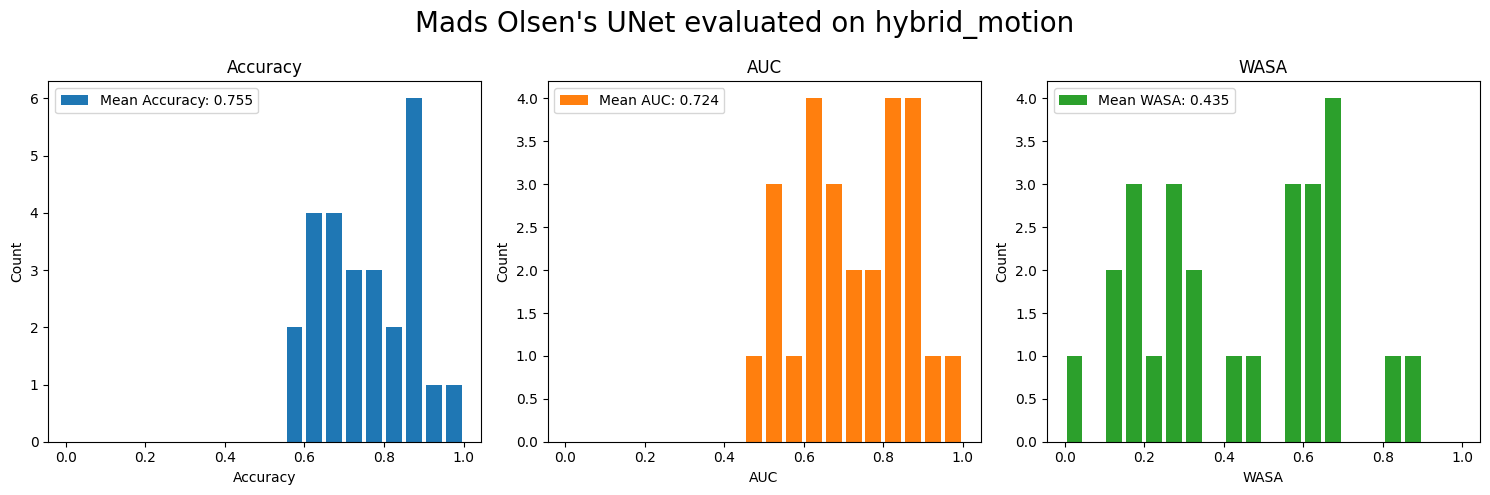

In [38]:
TRAIN_SET = walch.name
EVAL_SET = hybrid.name
PLOT_TITLE = f"Mads Olsen's UNet evaluated on {EVAL_SET}"

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

mo, _ = make_mo_model_and_processor(walch)
mo.load_model()
models = [mo]
splits = []
# model_fn = make_model(walch_data_processor_1D, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_unet[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_unet[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    # model, _ = pm.run_split(train_indices=train_ids, 
    #                         preprocessed_data_set=training_preprocessed_data, 
    #                         swc=mo, epochs=0, do_not_train=True)
    # models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()